## MicroCTD Report, Lake Zug, 5.2.2026

In [1]:
# imports
import ewgreaders as ewg
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os

### CTD

In [2]:
def extract_data_vars(dpath_L1, var, oom=True):
    data = []
    for p in os.listdir(dpath_L1):
        fpath = os.path.join(dpath_L1, p)
        
        ctdreader = ewg.ctd_reader.CTDReader(lake, year, date, fpath, serial_id)
        bathy = ctdreader.load_bathymetry()
        ds = ctdreader.load_from_L1()

        # metadata
        name = ds.attrs['Profile name']
        time = ds.attrs['Time of measurement (local)']
        xsc = int(ds.attrs['X Coordinate (CH1903)'])
        ysc = int(ds.attrs['Y Coordinate (CH1903)'])
        if oom:
            xsc = int(xsc + 2e6)
            ysc = int(ysc + 1e6)
        total_depth = bathy.sel(xsc=xsc, ysc=ysc).depth.item()

        # data quality
        if var == 'rho':
            mask = (ds['depth'].notnull()) & (ds['Temp_qual'] == 0) & (ds['Cond_qual'] == 0)
        else:
            mask = (ds['depth'].notnull()) & (ds[f'{var}_qual'] == 0)
        depth = ds['depth'][mask]
        vals = ds[var][mask]

        if var == 'DO_mg':    # convert to umol/L
            vals *= (1000/32)

        dat = pd.DataFrame({
            'depth': depth,
            var : vals
        })
        dat[['name', 'time', 'xsc', 'ysc', 'total_depth']] = name, time, xsc, ysc, total_depth
        data.append(dat)

    return pd.concat(data, ignore_index=True).sort_values(by=['time', 'depth'], ascending=True).reset_index(drop=True)


def plot_profiles_transect(data, var, t_start='00:00', t_end='24:00'):
    df = data[(data['time'] > t_start) & (data['time'] < t_end)]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(df['time'].unique()), figsize=(15, 5), sharex=True, sharey=True)
    if var == 'Temp':
        color = 'steelblue'
    elif var == 'DO_mg':
        color = 'green'
    elif var == 'rho':
        color = 'orange'
    elif var == 'Turb':
        color = 'brown'

    for i, (t, dat) in enumerate(df.groupby('time', sort=False)):
        ax[i].plot(dat[var], dat['depth'], color=color)
        ax[i].axhline(dat['total_depth'].unique()[0], color='gray', ls='--')

        ax[i].set_title(dat['name'].unique()[0])
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].grid(True)

    ax[0].set_ylabel('Depth [m]')
    ax[0].invert_yaxis()

    if var == 'Temp':
        fig.supxlabel('Temperature [°C]')
    elif var == 'DO_mg':
        fig.supxlabel('Dissolved Oxygen Concentration [mg/L]')
    elif var == 'rho':
        fig.supxlabel('Density [kg/m^3]')
    elif var == 'Turb':
        fig.supxlabel('Turbidity [FTU]')

    plt.tight_layout(w_pad=0.5)
    plt.show()

In [3]:
serial_id = '1807'
lake = 'Zugersee'
year = '2026'
date = '20260205'

dpath_L1 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/CTD/{date}/L1'

In [4]:
temp_data = extract_data_vars(dpath_L1, 'Temp')
do_data = extract_data_vars(dpath_L1, 'DO_mg')
rho_data = extract_data_vars(dpath_L1, 'rho')
rho_sg = ewg.signal.savitzky_golay(rho_data['rho'])
rho_ra = ewg.signal.rolling_average(rho_data['rho'], rho_data['depth'], 0.5)

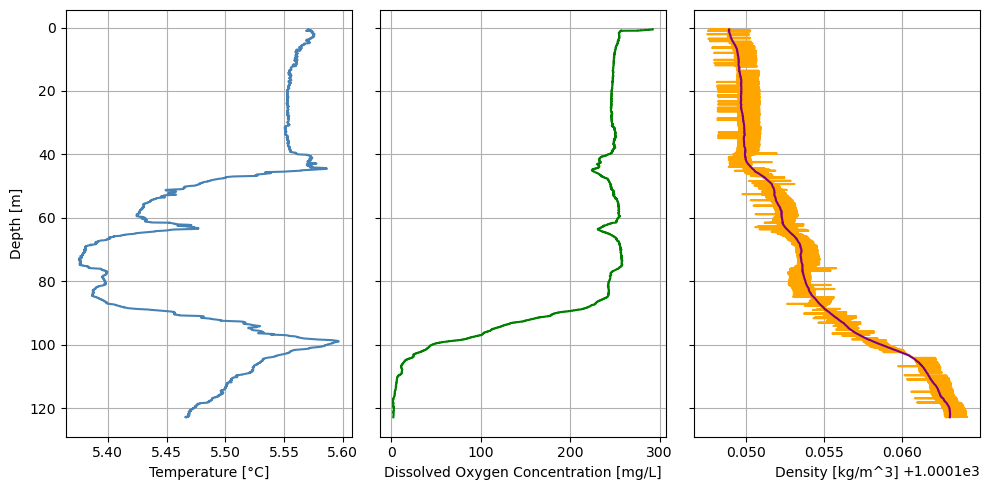

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)

ax[0].plot(temp_data['Temp'], temp_data['depth'], color='steelblue')
ax[1].plot(do_data['DO_mg'], do_data['depth'], color='green')
ax[2].plot(rho_data['rho'], rho_data['depth'], color='orange')
ax[2].plot(rho_sg, rho_data['depth'], color='purple')
#ax[2].plot(rho_ra, rho_data['depth'], color='black')

ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Temperature [°C]')
ax[1].set_xlabel('Dissolved Oxygen Concentration [mg/L]')
ax[2].set_xlabel('Density [kg/m^3]')

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].invert_yaxis()

plt.tight_layout()
plt.show()

### microCTD

In [7]:
dpath_L2 = f'Q:/Messdaten/Aphys_Hypothesis_data/{lake}/{year}/Microstructure/{date}/Level2'

In [8]:
ds1 = xr.open_dataset(os.path.join(dpath_L2, 'L2_DAT_072_down_prof1.nc'))
ds2 = xr.open_dataset(os.path.join(dpath_L2, 'L2_DAT_073_down_prof1.nc'))
ds3 = xr.open_dataset(os.path.join(dpath_L2, 'L2_DAT_073_down_prof2.nc'))

In [10]:
def plot_turbulence_FP07(ds):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5), sharey=True)
    palette = ['steelblue', 'palevioletred']

    mask_fast = ds['FAST_depth'] > 2
    mask_binned = ds['BINNED_depth'] > 2

    # temperature
    ax[0].plot(ds['FAST_fast_T1'][mask_fast], ds['FAST_depth'][mask_fast], color=palette[0], label='T1')
    ax[0].plot(ds['FAST_fast_T2'][mask_fast], ds['FAST_depth'][mask_fast], color=palette[1], label='T2')

    # espilon
    ax[1].plot(ds['BINNED_eps_T1'][mask_binned], ds['BINNED_depth'][mask_binned], color=palette[0], label='T1')
    ax[1].plot(ds['BINNED_eps_T2'][mask_binned], ds['BINNED_depth'][mask_binned], color=palette[1], label='T2')

    # K
    ax[2].plot(ds['BINNED_KOsbornCox_T1'][mask_binned], ds['BINNED_depth'][mask_binned], color=palette[0], label='T1')
    ax[2].plot(ds['BINNED_KOsbornCox_T2'][mask_binned], ds['BINNED_depth'][mask_binned], color=palette[1], label='T2')

    # chi
    ax[3].plot(ds['BINNED_Xi_T1'][mask_binned], ds['BINNED_depth'][mask_binned], color=palette[0], label='T1')
    ax[3].plot(ds['BINNED_Xi_T2'][mask_binned], ds['BINNED_depth'][mask_binned], color=palette[1], label='T2')

    ax[0].set_ylabel('Depth [m]')
    ax[0].set_xlabel('Temperature')
    ax[1].set_xlabel(r'$\epsilon$ [m^2/s^3]')
    ax[2].set_xlabel('K [m^2/s]')
    ax[3].set_xlabel(r'X [K^2/s]')

    for i in range(len(ax)):
        if i > 0:
            ax[i].set_xscale('log')
        ax[i].grid(True)
        ax[i].legend()

    ax[0].invert_yaxis()
    plt.tight_layout()
    plt.show()

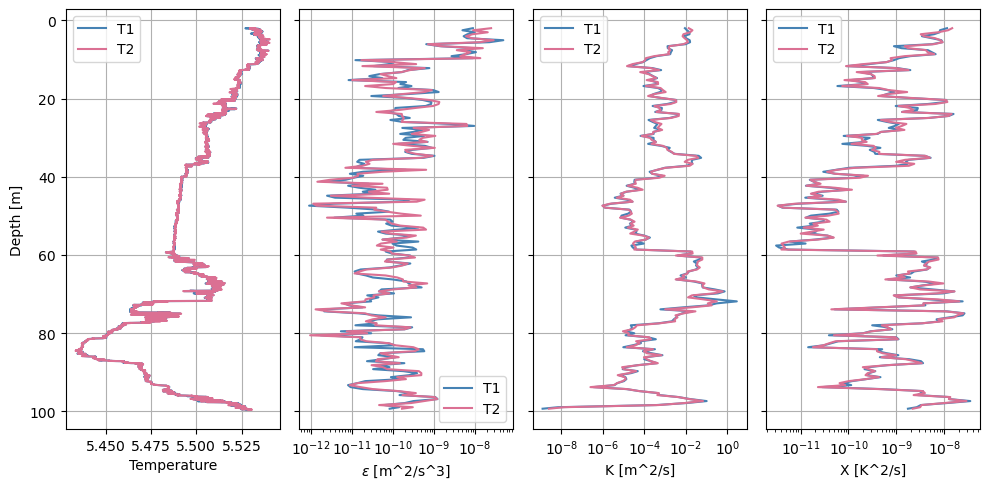

In [11]:
plot_turbulence_FP07(ds1)

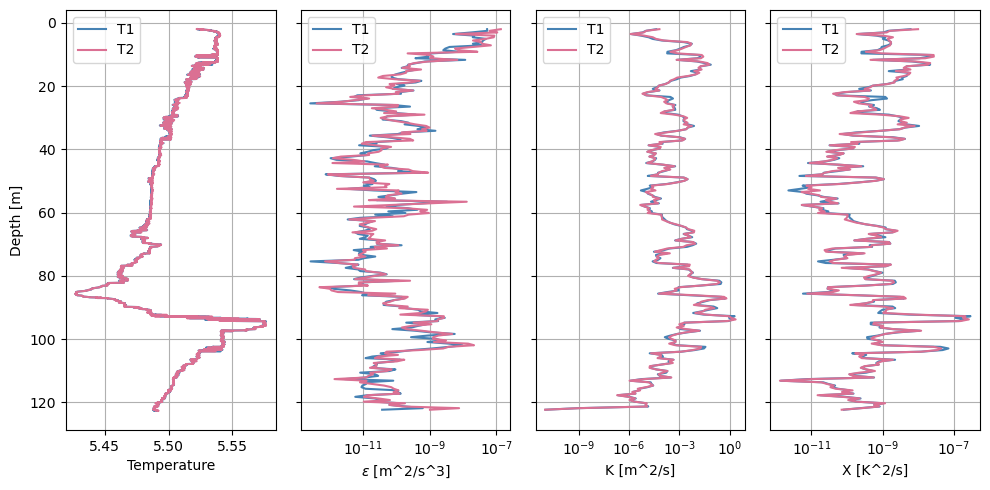

In [12]:
plot_turbulence_FP07(ds2)

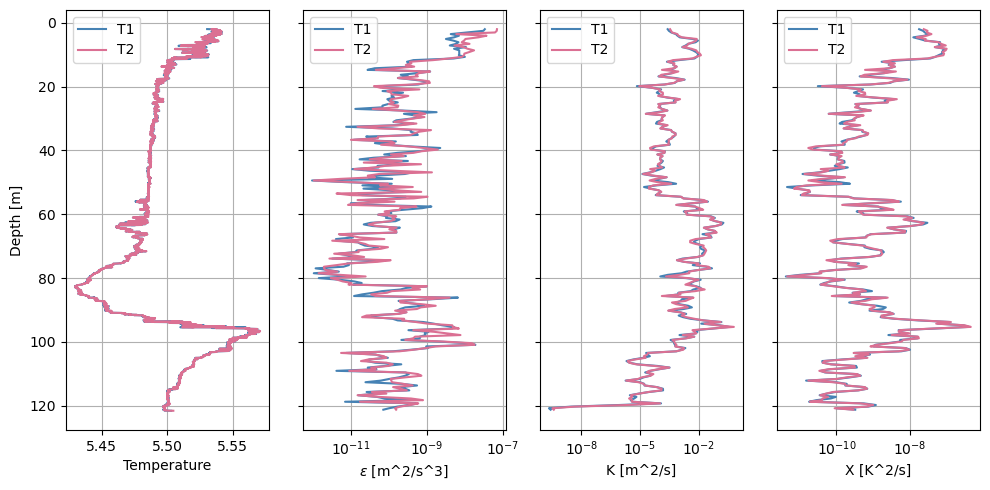

In [13]:
plot_turbulence_FP07(ds3)